# Implementación de un modelo de Deep Learning

In [9]:
from google.colab import drive
drive.mount('/content/drive')

#%cd "/content/drive/MyDrive/IA"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/IA


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"a01378649","key":"1dca8bf62fee4ec115bdb3be7cbe32ca"}'}

In [4]:
!rm -rf ~/.kaggle 

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           4854        154  1.0              
mvieira101/global-cost-of-living                                Global Cost of Living                                 1MB  2022-12-03 16:37:53            699         34  0.9705882        
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                      9KB  2022-10-06 08:55:25          21282        573  1.0              
thedevastator/jobs-dataset-from-glassdoor                   

## Selección de dataset

Se escogerá la base de SVHN que contiene imágenes RGB de números en diferentes lugares del mundo real. Asimismo, existe ruido alrededor como parte del ambiente, o incluso otros números. En este caso, solo nos interesa categorizar el número más centrado.

In [ ]:
!kaggle datasets download -d quanbk/svhndataset

svhndataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip svhndataset.zip

Archive:  svhndataset.zip
replace extra_32x32.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test_32x32.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train_32x32.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [7]:
import numpy as np
import keras
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras import layers

La base de datos incluye por defecto el set de entrenamiento y prueba, no obstante, hace falta alinear los datos para ser consumidos por el modelo. (Formatear a NHWC)

In [10]:
# Load the data

train_raw = loadmat('train_32x32.mat')
test_raw = loadmat('test_32x32.mat')

train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])
train_labels = train_raw['y']
test_labels = test_raw['y']

print(train_images.shape)
print(test_images.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [11]:
train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


Como anteriormente se explica, aunque existan dos números, el label provisto solo hace referencia al número del centro.

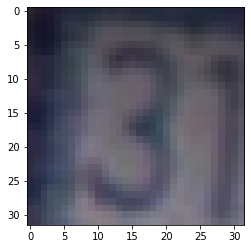

Label:  [3]


In [12]:
#Probando que las imágenes se hayan cargado de manera correcta
plt.imshow(train_images[8])
plt.show()

print('Label: ', train_labels[8])

Se utilizará One-Hot Encoding para representar las categorías (0 al 9)

In [13]:
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

Utilizaremos el set de entrenamiento inicial para crear el split de entrenamiento y validación para el modelo. (85% y 15% respectivamente)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels,
                                                  test_size=0.15, random_state=42)

Con esto confirmamos el número y dimensiones para los conjuntos de entrenamiento y validación.

In [15]:
print(X_train.shape)
print(X_val.shape)

(62268, 32, 32, 3)
(10989, 32, 32, 3)


Para incrementar el dominio de la naturaleza de las imágenes, añadiremos una capa de data augmentation para prevenir overfitting. Cabe destacar que solo se aplica rotación y zoom aleatorios para no cambiar efectivamente la categoría de la imagen. Por ejemplo, no se le pone random flip porque el número dejaría de ser reconocible.

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2)
    ]
)

## Definición del modelo

Se optó por el uso de una CNN tradicional de seis capas principales de convolución. Se utiliza BatchNormalization para establizar el comportamiento durante el entrenamiento. Además, Se utilizan capas de MaxPooling intermedias para realizar downsampling y agilizar el cómputo de predicciones, de igual manera, sirve para atenuar varianzas en la imagen como rotación o el zoom que puede suceder naturalmente. Igualmente, se añaden capas de Dropout para prevenir overfitting. 

Finalmente, los datos procesados son utilizados por una capa de softmax que predice la categoría.

In [17]:
#Se define una función que regresa la arquitectura en limpio cada vez que se llama
def Model1():
    return keras.Sequential([
    data_augmentation,
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(10,  activation='softmax')
])

No se utilizó ninguna técnica en especial para determinar el mejor learning rate (hyperparameter tunning), no obstante se sabe que para las CNN éste tiene que ser particularmente bajo, por lo que se decidió establecerlo como 0.001.

In [18]:
m1 = Model1()
early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(lr=0.001, amsgrad=True)
m1.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
history = m1.fit(X_train, y_train, batch_size=128,
                              epochs=40, validation_data=(X_val, y_val),
                              callbacks=[early_stopping]) 

Epoch 1/40
487/487 [==============================] - 17s 15ms/step - loss: 2.2588 - accuracy: 0.1971 - val_loss: 1.6696 - val_accuracy: 0.4624
Epoch 2/40
487/487 [==============================] - 7s 15ms/step - loss: 1.2731 - accuracy: 0.5689 - val_loss: 0.7322 - val_accuracy: 0.7662
Epoch 3/40
487/487 [==============================] - 9s 18ms/step - loss: 0.8175 - accuracy: 0.7376 - val_loss: 0.5490 - val_accuracy: 0.8264
Epoch 4/40
487/487 [==============================] - 7s 15ms/step - loss: 0.6888 - accuracy: 0.7802 - val_loss: 0.4973 - val_accuracy: 0.8428
Epoch 5/40
487/487 [==============================] - 7s 14ms/step - loss: 0.6303 - accuracy: 0.8014 - val_loss: 0.4714 - val_accuracy: 0.8502
Epoch 6/40
487/487 [==============================] - 7s 14ms/step - loss: 0.5862 - accuracy: 0.8145 - val_loss: 0.4984 - val_accuracy: 0.8420
Epoch 7/40
487/487 [==============================] - 7s 15ms/step - loss: 0.5636 - accuracy: 0.8225 - val_loss: 0.3846 - val_accuracy: 0.881

In [21]:
m1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)       

A continuación se muestra el accuracy del modelo, comparando su desempeño en el set de entrenamiento y validación. En este caso, se observa que ambos tienen pendiente positiva en todo momento. No existe una disparidad sustancial en ambas magnitudes por lo que no se trata de underfitting u overfitting. Cabe destacar que el accuracy de entrenamiento es más estable que el de validación, pero el segundo se mantiene lo suficiente para mantener la tendencia. Inclusive se puede apreciar menos variabilidad en las últimas épocas.

Text(0.5, 1.0, 'Epochs vs. Training and Validation Accuracy')

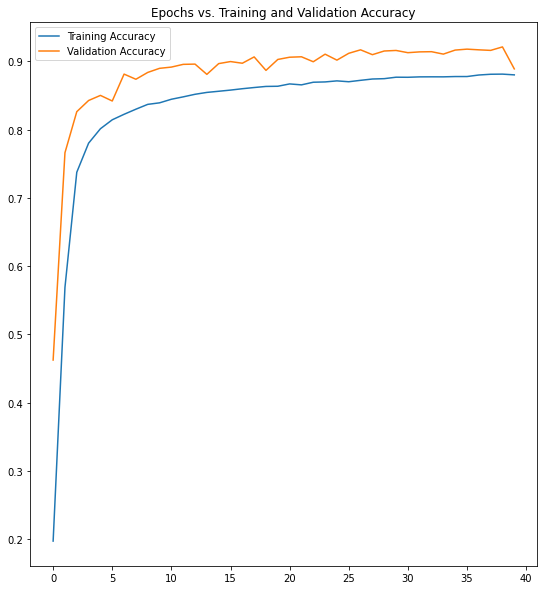

In [22]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')

## Evaluación del modelo

Para apreciar el comportamiento del modelo durante y al final del entrenamiento, se utilizará el KFold cross-validation para analizar su consistencia. Para ello, se determinará el accuracy promedio y su desviación estándar de todas las instancias experimentales. En este caso, tanto un accuracy promedio alto y una desviación estándar baja (qué tan entrenable es) apuntan a un modelo con mejor desempeño.

In [23]:
from sklearn.model_selection import KFold

En contraste a la primera instancia del modelo, cada iteración del KFold se entrenerán solo durante 30 épocas.

In [24]:
#80% train y 20% validation
n_split = 5
k_eval = []

for train_i ,val_i in KFold(n_split).split(train_images):
  x_train,x_val= train_images[train_i], train_images[val_i]
  y_t,y_v= train_labels[train_i], train_labels[val_i]

  aux = Model1()

  aux.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  aux.fit(x_train, y_t,epochs=30)

  eval = aux.evaluate(x_val,y_v)
  k_eval.append(eval[1])

print('Model evaluation ', eval)

Epoch 1/30
1832/1832 [==============================] - 14s 7ms/step - loss: 2.2361 - accuracy: 0.1990
Epoch 2/30
1832/1832 [==============================] - 13s 7ms/step - loss: 1.3373 - accuracy: 0.5490
Epoch 3/30
1832/1832 [==============================] - 13s 7ms/step - loss: 0.8466 - accuracy: 0.7276
Epoch 4/30
1832/1832 [==============================] - 13s 7ms/step - loss: 0.7314 - accuracy: 0.7672
Epoch 5/30
1832/1832 [==============================] - 14s 7ms/step - loss: 0.6687 - accuracy: 0.7891
Epoch 6/30
1832/1832 [==============================] - 13s 7ms/step - loss: 0.6327 - accuracy: 0.8005
Epoch 7/30
1832/1832 [==============================] - 12s 7ms/step - loss: 0.5984 - accuracy: 0.8102
Epoch 8/30
1832/1832 [==============================] - 12s 7ms/step - loss: 0.5797 - accuracy: 0.8178
Epoch 9/30
1832/1832 [==============================] - 12s 7ms/step - loss: 0.5562 - accuracy: 0.8242
Epoch 10/30
1832/1832 [==============================] - 12s 7ms/step - l

Un accuracy de 90 puede ser considerado como plausible dependiendo de la tarea que se le asigne. De igual manera, la razón entre la desviación estándar de la media apuntan a que dicho accuracy posee una estabilidad sustancial (<1%).

In [25]:
result = np.array(k_eval)
print("Mean accuracy: ", result.mean())
print("Standard deviation: ", result.std())

Mean accuracy:  0.9082136034965516
Standard deviation:  0.004157153818691504


Se muestan los resultados sobre el set de prueba provisto por el dataset. Es notable que tuvo un accuracy sustancialmente más alto que el promedio del KFold. Esto puede deberse a la capa de data augmentation que altera las imágenes para prevenir overfitting sobre el set de entrenamiento, pero que resulta benéfico para su desempeño en datos no vistos previamente.

In [26]:
test_loss, test_acc = m1.evaluate(x=test_images, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9002 
Test loss is: 0.3368


# Segundo modelo (posibles mejoras)

### Hacer la red más profunda

El primer modelo consta de 6 capas de convolusión, 3 con un tamaño de output de 32 y 3 de tamaño de 64. Entonces, una primera propuesta es hacer la red más profunda agregando otras tres capas de convolusión con tamaño de output mayor (128), para que se mantenga la complejidad de las capas intermedias. (densidad de output intermedio). Esto implica tener más parámetros para interpretar diferencias más sutiles.

### Agregar skip connections

Al hacer la red más profunda nos podemos encontrar con problemas de variabilidad no deseada en el gradiente de la función de costo (shattered gradient), por lo que conexiones residuales pueden ayudar a aminorar este fenómeno.

### Agregar una capa densa al final

Aunque es posible que una red densa provoque overfitting al aprender las características proporcionadas por las CNN, podría ser útil para mejorar el accuracy un poco más en caso de que la CNN por sí sola no alcance resultados deseados.

### Alinear Max-Pooling con la red que incrementa el número de kernels

Aunque el beneficio no sea asegurado, se puede interpretar como la multiplicación del número de celdas que un kernel "ve" en cada uno de los inputs y el número de kernel per se. Si se mantiene el número de kernels después de un Max Pooling, dichos kernels verán una simplificación de los inputs anteriores y probablemente carezcan de información valiosa, y esto se propagará a las capas siguientes. Esto asume que la información perdida por el Max Pooling en efecto es significativa, pero se sigue tomando las ventajas del pooling aplicándolo en un momento más oportuno.


In [27]:
def M2():    
    input = keras.Input(shape=(32, 32, 3))

    data_augmentation = keras.Sequential(
        [
            layers.RandomRotation(0.2),
            layers.RandomZoom(0.2),
        ]
    )

    x = data_augmentation(input)

    x = layers.Rescaling(1./255)(x)

    for size in [32, 64, 128]:
        residual = x
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)
        x = layers.Activation("relu")(x)

        x = layers.Dropout(0.3)(x)
        x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)
        x = layers.Activation("relu")(x)

        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)
        x = layers.Activation("relu")(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = layers.Dropout(0.3)(x)
        

        residual = layers.Conv2D(
            size, 1, strides=2, padding="same", use_bias=False)(residual)

        x = layers.add([x, residual])

    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    model2 = keras.Model(inputs=input, outputs=outputs)
    return model2

model2 = M2()

Al tratarse de una red algo más profunda, se reducirá un poco el learning rate respecto al anterior para aminorar un posible fenómento de exploding gradient.

In [28]:
early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(lr=.0008, amsgrad=True)
model2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
history2 = model2.fit(X_train, y_train, batch_size=128, 
                      epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
487/487 [==============================] - 14s 26ms/step - loss: 2.2382 - accuracy: 0.1939 - val_loss: 1.8839 - val_accuracy: 0.3352
Epoch 2/40
487/487 [==============================] - 12s 25ms/step - loss: 1.2304 - accuracy: 0.5842 - val_loss: 0.5994 - val_accuracy: 0.8114
Epoch 3/40
487/487 [==============================] - 12s 25ms/step - loss: 0.6948 - accuracy: 0.7756 - val_loss: 0.4943 - val_accuracy: 0.8438
Epoch 4/40
487/487 [==============================] - 12s 25ms/step - loss: 0.5620 - accuracy: 0.8201 - val_loss: 0.3786 - val_accuracy: 0.8843
Epoch 5/40
487/487 [==============================] - 12s 25ms/step - loss: 0.4983 - accuracy: 0.8443 - val_loss: 0.3604 - val_accuracy: 0.8907
Epoch 6/40
487/487 [==============================] - 12s 25ms/step - loss: 0.4608 - accuracy: 0.8564 - val_loss: 0.3346 - val_accuracy: 0.8984
Epoch 7/40
487/487 [==============================] - 12s 25ms/step - loss: 0.4326 - accuracy: 0.8660 - val_loss: 0.3095 - val_accuracy:

In [49]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential_7 (Sequential)      (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['sequential_7[0][0]']           
                                                                                                  
 batch_normalization_18 (BatchN  (None, 32, 32, 3)   12          ['rescaling[0][0]']              
 ormalization)                                                                                

No se observa underfitting u overfitting al igual que en el primer modelo (no se separan las líneas). No obstante, los valores de accuracy tanto de entrenamiento como validación son superiores. Incluso la separación entre éstas es menor. Esto indica un "fit" superior. Además, el accuracy de validación se estabiliza más rápido que en la primera arquitectura.

Text(0.5, 1.0, 'Epochs vs. Training and Validation Accuracy')

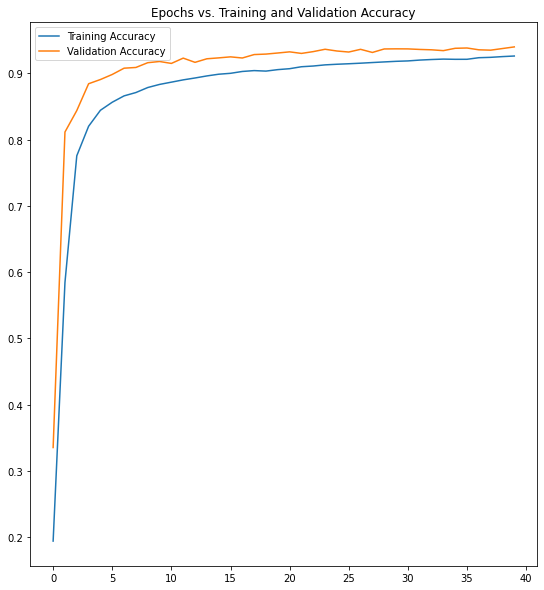

In [30]:
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')

## Evaluación

Se procederá a realizar la mismo procedimiento de KFold cross-validation que el modelo anterior. (k=5)

In [31]:
n_split = 5
k_eval = []

for train_i ,val_i in KFold(n_split).split(train_images):
  x_train,x_val= train_images[train_i], train_images[val_i]
  y_t,y_v= train_labels[train_i], train_labels[val_i]

  aux = M2()

  aux.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  aux.fit(x_train, y_t,epochs=30)

  eval = aux.evaluate(x_val,y_v)
  k_eval.append(eval[1])

print('Model evaluation ', eval)

Epoch 1/30
1832/1832 [==============================] - 19s 10ms/step - loss: 2.0194 - accuracy: 0.2699
Epoch 2/30
1832/1832 [==============================] - 18s 10ms/step - loss: 0.8311 - accuracy: 0.7285
Epoch 3/30
1832/1832 [==============================] - 17s 10ms/step - loss: 0.5993 - accuracy: 0.8096
Epoch 4/30
1832/1832 [==============================] - 17s 10ms/step - loss: 0.5223 - accuracy: 0.8331
Epoch 5/30
1832/1832 [==============================] - 17s 9ms/step - loss: 0.4821 - accuracy: 0.8504
Epoch 6/30
1832/1832 [==============================] - 17s 10ms/step - loss: 0.4525 - accuracy: 0.8580
Epoch 7/30
1832/1832 [==============================] - 17s 9ms/step - loss: 0.4322 - accuracy: 0.8666
Epoch 8/30
1832/1832 [==============================] - 18s 10ms/step - loss: 0.4130 - accuracy: 0.8726
Epoch 9/30
1832/1832 [==============================] - 17s 9ms/step - loss: 0.4004 - accuracy: 0.8773
Epoch 10/30
1832/1832 [==============================] - 17s 9ms/st

El modelo que implementa las sugerencias presentó un incremento de .03 apróximadamente y mantuvo una relación con la desviación estándar similar al primer modelo (<1%). Esto es una mejora significativa.

In [32]:
result = np.array(k_eval)
print("Mean accuracy: ", result.mean())
print("Standard deviation: ", result.std())

Mean accuracy:  0.9346819877624511
Standard deviation:  0.002219978995536582


Finalmente se muestra el desempeño de la versión entrenada por 40 épocas sobre el set de prueba. El accuracy incrementó .03 aproximadamente , aunque no fue la misma magnitud incremental que en los set de validación, aún fue una mejora significativa. Se tendría también que evaluar ambos modelos al entrenarse en todavía más épocas para conocer su convergencia.

In [33]:
test_loss, test_acc = model2.evaluate(x=test_images, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9469 
Test loss is: 0.1926


## Predicciones

Se define una breve función para visualizar las predicciones del modelo.

In [47]:
def m2_predict(index):
    plt.imshow(test_images[index])
    plt.show()

    print('Label: ', (np.argmax(test_labels[index]) + 1) % 10)
    print('Predicted label: ', (np.argmax(model2.predict(test_images[index].reshape((1,32,32,3)))) + 1) % 10)

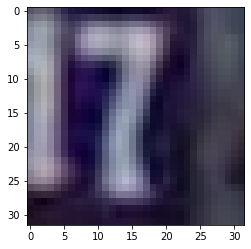

Label:  7
1/1 [==============================] - 0s 27ms/step
Predicted label:  7


In [48]:
m2_predict(123)